<a href="https://colab.research.google.com/github/Charlotte-99/Y3Project/blob/main/On_the_fly_image_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#On-the-fly image generation

In [1]:
# Mount google drive folder with .fits maps
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Change directory to project folder
import os
os.chdir('/content/drive/My Drive/Project')

In [8]:
from matplotlib.colors import ListedColormap
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

## Experimenting with Dataset

Here we experiment with creating a data pipeline.

First we will experiment with a simple dataset with only two images (one for each class). We begin by loading the images.

In [9]:
cmb = np.concatenate([np.load('cmb_map0_extracts.npy'),
                      np.load('cmb_map1_extracts.npy'),
                      np.load('cmb_map2_extracts.npy')])

string = np.concatenate([np.load('map1n_allz_rtaapixlw_2048_1_extracts.npy'),
                        np.load('map1n_allz_rtaapixlw_2048_2_extracts.npy'),
                        np.load('map1n_allz_rtaapixlw_2048_3_extracts.npy')])

cmap = ListedColormap(np.loadtxt('planck_map.txt')/255.)

We will select two images from the cmb array to use as our toy dataset.

In [10]:
X_input = cmb[:2][..., np.newaxis]
y_input = np.array([0, 1])

print(X_input.shape)
print(y_input.shape)

(2, 200, 200, 1)
(2,)


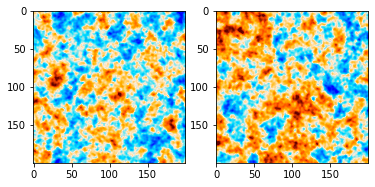

In [11]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(X_input[0][:, :, 0], cmap=cmap, vmin=-300e-6, vmax=300e-6)
ax[1].imshow(X_input[1][:, :, 0], cmap=cmap, vmin=-300e-6, vmax=300e-6)

We will now build a tensorflow dataset using the tensor slices routine.

In [12]:
dataset = tf.data.Dataset.from_tensor_slices((X_input, y_input))

First we will try some simple augmentations just to test how this works. Here we try running rotations on both sets regardless of the label.

In [13]:
def rotation(image, label):
  image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0,
                                          maxval=4, dtype=tf.int32))
  return image, label

We call the map method to apply transformations to the dataset and to generate a new dataset.

In [14]:
dataset = dataset.map(rotation)

Running this section multiple times, we will see both images undergoing random rotations.

(200, 200, 1)
0
(200, 200, 1)
1


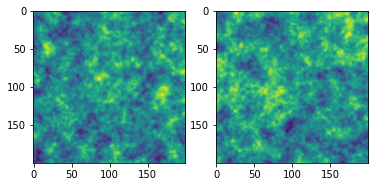

In [19]:
fig, ax = plt.subplots(1, 2)
n = 0
for image, label in dataset:
  print(image.shape)
  ax[n].imshow(np.reshape(image, (200, 200)))
  print(int(label))
  n += 1

This is hopeful...now let's try to change it so that it only applies a transformation for a certain class by using tf.cond, which seems to behave much like an if/else condition.

We will apply rotations to the first image (with a label 0) but leave the other image unaffected.

In [20]:
def selective_rotation(image, label):
  x = np.int(label)

  def rotate():
    return tf.image.rot90(image, tf.random.uniform(shape=[], minval=0,
                                          maxval=4, dtype=tf.int32)), label
  def do_nothing():
    return image, label

  return tf.cond(x == 0, true_fn = rotate, false_fn = do_nothing)

In [21]:
dataset = tf.data.Dataset.from_tensor_slices((X_input, y_input))
dataset = dataset.map(selective_rotation)

Running the code below multiple times, we will see the first image rotating by random amounts whilst the second image remains unaffected.

(200, 200, 1)
0
(200, 200, 1)
1


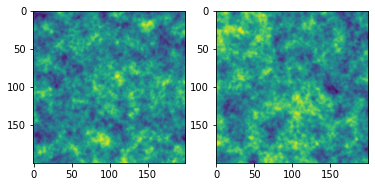

In [25]:
fig, ax = plt.subplots(1, 2)
n = 0
for image, label in dataset:
  print(image.shape)
  ax[n].imshow(np.reshape(image, (200, 200)))
  print(int(label))
  n += 1

Great, it works! Only the first image changes with each run. Now let's try adding the string maps into the mix. We will apply rotations and flips to any images labelled 0 and apply a string map transformation to any images labelled 1.

The code here is a bit messy but it works for the moment.

In [26]:
def selective_string_maps(image, label):
  x = np.int(label)
  def rotate_and_flip():
    image2 = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0,
                                          maxval=4, dtype=tf.int32))
    image2 = tf.image.random_flip_up_down(image2)
    image2 = tf.image.random_flip_left_right(image2)
    return image2, label

  def add_string():
    alpha = 5*1e-6
    string_choice = np.random.randint(0, 100)
    string_map = string[string_choice][..., np.newaxis]*alpha
    image2 = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0,
                                          maxval=4, dtype=tf.int32))
    string2 = tf.image.rot90(string_map, tf.random.uniform(shape=[], minval=0,
                                          maxval=4, dtype=tf.int32))
    image2 = tf.add(image2, string2)
    return image2, label
  
  return tf.cond(x == 0, true_fn = rotate_and_flip, false_fn = add_string)

In [28]:
dataset = tf.data.Dataset.from_tensor_slices((X_input, y_input))
dataset = dataset.map(selective_string_maps)

We expect the first image to just undergo rotations, while the second image will have some random rotations and random string map applied.

(200, 200, 1)
0
(200, 200, 1)
1


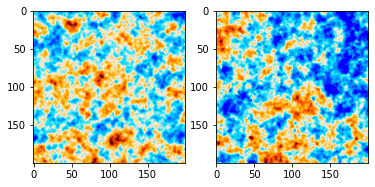

In [30]:
fig, ax = plt.subplots(1, 2)
n = 0
for image, label in dataset:
  print(image.shape)
  ax[n].imshow(np.reshape(image, (200, 200)), cmap=cmap, vmin=-300e-6, vmax=300e-6)
  print(int(label))
  n += 1